In [ ]:
# Importing Libraries

In [6]:
!wget --header="Host: doc-04-8s-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_ucu55st84n9vmnrguf06csv12kkku9tn_nonce=8c5pco6po95mg" --header="Connection: keep-alive" "https://doc-04-8s-docs.googleusercontent.com/docs/securesc/6qasdsvtcepj72nj3126fhrlbctlsaju/eefs3cvrbm4u1ju1gt9mistifrov2g2e/1548136800000/06629147635963609455/12370343985631133257/118toouH8ifByKJHmmowyjOjGyir-YAvi?e=download&nonce=8c5pco6po95mg&user=12370343985631133257&hash=ue43mlk075cdbk64ucdojcp3urk3ujmj" -O "HumanActivityRecognition.zip" -c

--2019-01-22 07:30:42--  https://doc-04-8s-docs.googleusercontent.com/docs/securesc/6qasdsvtcepj72nj3126fhrlbctlsaju/eefs3cvrbm4u1ju1gt9mistifrov2g2e/1548136800000/06629147635963609455/12370343985631133257/118toouH8ifByKJHmmowyjOjGyir-YAvi?e=download&nonce=8c5pco6po95mg&user=12370343985631133257&hash=ue43mlk075cdbk64ucdojcp3urk3ujmj
Resolving doc-04-8s-docs.googleusercontent.com (doc-04-8s-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to doc-04-8s-docs.googleusercontent.com (doc-04-8s-docs.googleusercontent.com)|74.125.141.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘HumanActivityRecognition.zip’

HumanActivityRecogn     [     <=>            ]  85.62M  58.7MB/s    in 1.5s    

2019-01-22 07:30:44 (58.7 MB/s) - ‘HumanActivityRecognition.zip’ saved [89781419]



In [7]:
!unzip HumanActivityRecognition.zip

Archive:  HumanActivityRecognition.zip
   creating: HAR/
  inflating: HAR/.DS_Store           
   creating: __MACOSX/
   creating: __MACOSX/HAR/
  inflating: __MACOSX/HAR/._.DS_Store  
   creating: HAR/.ipynb_checkpoints/
  inflating: HAR/.ipynb_checkpoints/HAR_EDA-checkpoint.ipynb  
  inflating: HAR/.ipynb_checkpoints/HAR_LSTM-checkpoint.ipynb  
  inflating: HAR/.ipynb_checkpoints/HAR_LSTM_1-checkpoint.ipynb  
  inflating: HAR/.ipynb_checkpoints/HAR_PREDICTION_MODELS-checkpoint.ipynb  
  inflating: HAR/HAR_EDA.ipynb       
  inflating: __MACOSX/HAR/._HAR_EDA.ipynb  
  inflating: HAR/HAR_LSTM.ipynb      
  inflating: __MACOSX/HAR/._HAR_LSTM.ipynb  
  inflating: HAR/HAR_PREDICTION_MODELS.ipynb  
  inflating: __MACOSX/HAR/._HAR_PREDICTION_MODELS.ipynb  
  inflating: HAR/t-sne_perp_10_iter_1000.png  
  inflating: __MACOSX/HAR/._t-sne_perp_10_iter_1000.png  
  inflating: HAR/t-sne_perp_20_iter_1000.png  
  inflating: __MACOSX/HAR/._t-sne_perp_20_iter_1000.png  
  inflating: HAR/t-sne_perp_

In [43]:
!pip3 install hyperas
!pip3 install hyperopt

In [1]:
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd
import numpy as np

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [2]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [3]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [4]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [5]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [6]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [7]:
def load_data():
    import numpy as np
    
    # Raw data signals
    # Signals are from Accelerometer and Gyroscope
    # The signals are in x,y,z directions
    # Sensor signals are filtered to have only body acceleration
    # excluding the acceleration due to gravity
    # Triaxial acceleration from the accelerometer is total acceleration
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
    ]
    # Utility function to load the load
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)
      
    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = 'HAR/UCI_HAR_Dataset/' + subset+ '/y_'+ subset+'.txt'
        y = _read_csv(filename)[0]

        return pd.get_dummies(y).as_matrix()
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = 'HAR/UCI_HAR_Dataset/'+subset+'/Inertial Signals/'+signal+'_'+subset+'.txt'
            signals_data.append(
                _read_csv(filename).as_matrix()
            ) 

          # Transpose is used to change the dimensionality of the output,
          # aggregating the signals by combination of sample/timestep.
          # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    Y_train, Y_test = load_y('train'), load_y('test')
    return X_train,Y_train,X_test,Y_test

In [8]:
def model(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    # Configuring the parameters
    model.add(LSTM({{choice([64, 128, 256])}}, input_shape=(128, 9)))
    # Adding a dropout layer
    model.add(Dropout({{uniform(0, 1)}}))
    # Adding a dense output layer with sigmoid activation
    model.add(Dense(6, activation='sigmoid'))
    # Compiling the model
    model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    # Training the model
    history = model.fit(X_train,
            Y_train,
            batch_size={{choice([16,32,64])}},
            validation_data=(X_test, Y_test),
            epochs=30)
    score, acc = model.evaluate(X_test, Y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model,'history.val_loss':history.history['val_loss'], 'history.val_acc': history.history['val_acc'],
    'history.loss': history.history['loss'], 'history.acc': history.history['acc']
    }

In [10]:
from hyperas import optim
from hyperopt import tpe,Trials,STATUS_OK

In [11]:
trials = Trials()

In [12]:
best_run, best_model = optim.minimize(model=model,
                                          data=load_data,
                                          max_evals=10,
                                          algo=tpe.suggest,
                                          notebook_name='HAR_LSTM',
                                          trials=trials
                                     )

>>> Imports:
#coding=utf-8

try:
    import warnings
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import LSTM
except:
    pass

try:
    from keras.layers.core import Dense, Dropout
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperopt import tpe, Trials, STATUS_OK
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from collections import defaultdict
except:
    pass

>>> Hyperas search space:

def get_space():
    return {
        'LSTM': hp.choice('LSTM', [64, 128, 256]),
        'Dropout': hp.uniform('Dropout', 0, 1),
        'batch_size': hp.choice('batch_size', [16,32,64]),
    }

>>> Data
   1: 
   2:

Epoch 29/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.1629 - acc: 0.9403 - val_loss: 0.3990 - val_acc: 0.8989
Epoch 30/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.1372 - acc: 0.9446 - val_loss: 0.3375 - val_acc: 0.8968
Test accuracy: 0.8968442483881914
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 120s 16ms/step - loss: 1.3790 - acc: 0.4163 - val_loss: 1.5887 - val_acc: 0.3607
Epoch 2/30
7352/7352 [==============================] - 118s 16ms/step - loss: 1.2000 - acc: 0.5128 - val_loss: 0.9426 - val_acc: 0.5609
Epoch 3/30
7352/7352 [==============================] - 123s 17ms/step - loss: 0.9695 - acc: 0.5828 - val_loss: 0.9686 - val_acc: 0.4720
Epoch 4/30
7352/7352 [==============================] - 119s 16ms/step - loss: 0.8395 - acc: 0.6304 - val_loss: 0.8240 - val_acc: 0.5982
Epoch 5/30
7352/7352 [==============================] - 116s 16ms/step - loss: 0.9826 - acc: 0.575

Epoch 26/30
7352/7352 [==============================] - 128s 17ms/step - loss: 0.1401 - acc: 0.9490 - val_loss: 0.3741 - val_acc: 0.9230
Epoch 27/30
7352/7352 [==============================] - 128s 17ms/step - loss: 0.1402 - acc: 0.9489 - val_loss: 0.3374 - val_acc: 0.9267
Epoch 28/30
7352/7352 [==============================] - 129s 18ms/step - loss: 0.1493 - acc: 0.9509 - val_loss: 0.2570 - val_acc: 0.9186
Epoch 29/30
7352/7352 [==============================] - 129s 18ms/step - loss: 0.1295 - acc: 0.9517 - val_loss: 0.4193 - val_acc: 0.9158
Epoch 30/30
7352/7352 [==============================] - 130s 18ms/step - loss: 0.1539 - acc: 0.9423 - val_loss: 0.4205 - val_acc: 0.9067
Test accuracy: 0.9066847641871749
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 73s 10ms/step - loss: 1.4068 - acc: 0.3814 - val_loss: 1.3328 - val_acc: 0.4404
Epoch 2/30
7352/7352 [==============================] - 69s 9ms/step - loss: 1.2975 - acc: 0

Epoch 25/30
7352/7352 [==============================] - 61s 8ms/step - loss: 0.2229 - acc: 0.9362 - val_loss: 0.3305 - val_acc: 0.9101
Epoch 26/30
7352/7352 [==============================] - 61s 8ms/step - loss: 0.2008 - acc: 0.9408 - val_loss: 0.4580 - val_acc: 0.8955
Epoch 27/30
7352/7352 [==============================] - 61s 8ms/step - loss: 0.2664 - acc: 0.9319 - val_loss: 0.6328 - val_acc: 0.8992
Epoch 28/30
7352/7352 [==============================] - 62s 8ms/step - loss: 0.2243 - acc: 0.9397 - val_loss: 0.8507 - val_acc: 0.8714
Epoch 29/30
7352/7352 [==============================] - 61s 8ms/step - loss: 0.2212 - acc: 0.9363 - val_loss: 0.3582 - val_acc: 0.9111
Epoch 30/30
7352/7352 [==============================] - 60s 8ms/step - loss: 0.1751 - acc: 0.9430 - val_loss: 0.4272 - val_acc: 0.9019
Test accuracy: 0.9019341703427214
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 36s 5ms/step - loss: 1.3341 - acc: 0.4143 - va

Epoch 24/30
7352/7352 [==============================] - 125s 17ms/step - loss: 0.1471 - acc: 0.9489 - val_loss: 0.2361 - val_acc: 0.9243
Epoch 25/30
7352/7352 [==============================] - 125s 17ms/step - loss: 0.1464 - acc: 0.9445 - val_loss: 0.4671 - val_acc: 0.9080
Epoch 26/30
7352/7352 [==============================] - 125s 17ms/step - loss: 0.1644 - acc: 0.9442 - val_loss: 0.6430 - val_acc: 0.8955
Epoch 27/30
7352/7352 [==============================] - 128s 17ms/step - loss: 0.1412 - acc: 0.9467 - val_loss: 0.2782 - val_acc: 0.9399
Epoch 28/30
7352/7352 [==============================] - 127s 17ms/step - loss: 0.1347 - acc: 0.9499 - val_loss: 0.4034 - val_acc: 0.9087
Epoch 29/30
7352/7352 [==============================] - 127s 17ms/step - loss: 0.1309 - acc: 0.9510 - val_loss: 0.3121 - val_acc: 0.9091
Epoch 30/30
7352/7352 [==============================] - 128s 17ms/step - loss: 0.1410 - acc: 0.9483 - val_loss: 0.2925 - val_acc: 0.9294
Test accuracy: 0.9294197488971836


In [14]:
X_train, Y_train, X_test, Y_test = load_data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

Evalutation of best performing model:
2947/2947 [==============================] - 8s 3ms/step
[0.24316548304311456, 0.9358669833729216]
Best performing model chosen hyper-parameters:
{'LSTM': 2, 'Dropout': 0.288662535902546, 'batch_size': 1}


In [16]:
model = Sequential()
# Configuring the parameters
model.add(LSTM(256, input_shape=(128, 9)))
# Adding a dropout layer
model.add(Dropout(0.288662535902546))
# Adding a dense output layer with sigmoid activation
model.add(Dense(6, activation='sigmoid'))
# Compiling the model
model.compile(loss='categorical_crossentropy',
          optimizer='rmsprop',
          metrics=['accuracy'])
# Training the model
history = model.fit(X_train,
        Y_train,
        batch_size=32,
        validation_data=(X_test, Y_test),
        epochs=30)
score, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', acc)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 96s 13ms/step - loss: 1.3417 - acc: 0.4068 - val_loss: 1.1853 - val_acc: 0.5243
Epoch 2/30
7352/7352 [==============================] - 93s 13ms/step - loss: 1.1744 - acc: 0.4770 - val_loss: 1.1168 - val_acc: 0.4700
Epoch 3/30
7352/7352 [==============================] - 92s 13ms/step - loss: 1.0587 - acc: 0.5163 - val_loss: 0.9571 - val_acc: 0.5222
Epoch 4/30
7352/7352 [==============================] - 92s 12ms/step - loss: 0.7292 - acc: 0.6752 - val_loss: 0.9916 - val_acc: 0.5996
Epoch 5/30
7352/7352 [==============================] - 92s 13ms/step - loss: 0.6078 - acc: 0.7599 - val_loss: 0.5368 - val_acc: 0.7767
Epoch 6/30
7352/7352 [==============================] - 92s 13ms/step - loss: 0.4263 - acc: 0.8441 - val_loss: 0.3994 - val_acc: 0.8656
Epoch 7/30
7352/7352 [==============================] - 93s 13ms/step - loss: 0.2956 - acc: 0.8993 - val_loss: 0.2945 - val_acc: 0.8907


In [22]:
import matplotlib.pyplot as plt

In [26]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

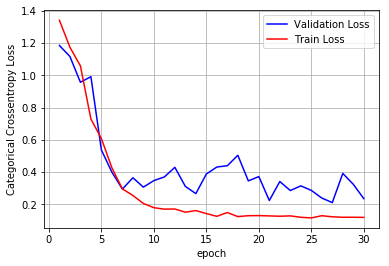

In [27]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,31))


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### Steps 

1. Hyperas is used for hyperparmater tuning.
2. Number of Epoch =30 
3. model() function contains the model for hyperparameter tuning.
4. load_data() is used for loading the data.
5. for LSTM I used values 64, 128, 256
6. for Dropouts , I take value from uniform distribution of 0 and 1 and apply on each model
7. for batch size , I used values 16,32,64
8. After hyperparameter tuning, I got no of LSTM-256,0.288662535902546-dropout rate, 32-batch size as the best values.
9. With these values, I train the model and got the test accuracy of 92.6%
10. Train and validaton loss is also plotted for the best model.

### Summary

| LSTM | Dropout | Batch size | Accuracy |
|------|---------|------------|----------|
| 256  | 0.29    | 32         | 92.6     |